In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import scipy
import scipy.stats
from scipy.stats import norm
import math
import random
import matplotlib.pyplot as plt
import pickle
from EM import EM
from plot import plot

### Potential Issues of EM
* sometimes, the value of sigma_0 becomes smaller than the resolution of dtype float64 (1e-15) that it becomes zero. Making loglik nan. 

### Data Generation

In [2]:
class Model:
    # num_tseries is the number of time series generated by Model, each is time_length long
    # missing is the probability of an observation missing, default to zero 
    def __init__(self, time_length, num_tseries, missing=0):
        self.T = time_length
        self.num_tseries = num_tseries
        # model parameters
        self.A = np.array([[-.9, -.8], [-.5, -.3]]) # the coefficients a_j's stored in a matrix
        self.b = np.array([.6, .4])
        self.num_treatments = self.A.shape[1]
        self.num_chronic = self.b.shape[0]
        # noise are the variance, not standard deviation
        # noise for transition should be larger than noise for observation
        self.noise_0 = .1
        self.noise_1 = 1
        self.noise_2 = .01
        self.init_z = 6
        self.missing = missing
        # simulated data
        self.z = np.zeros((self.num_tseries, self.T))
        self.y = np.zeros((self.num_tseries, self.T))
        self.X = np.zeros((self.num_tseries, self.T, self.num_treatments))
        self.c = np.zeros((self.num_tseries, self.num_chronic))
        self.pi = np.zeros((self.num_tseries, self.T))
        
    def set_X(self, n):
        for t in range(self.T):
            self.X[n, t, :] = np.random.binomial(n=1, p=0.0, size=self.A.shape[1])# np.random.randint(2, size = self.num_treatments)

    def set_c(self, n):
        self.c[n, :] = np.random.binomial(n=1, p=0.0, size=self.num_chronic)#np.random.randint(2, size = self.num_chronic)
        
    def transition(self, prev):
        z = np.random.normal(prev, np.sqrt(self.noise_1), 1)
        return z

    def emission(self, z, n, t):
        treatment_effect = 0
        for j in range(np.shape(self.A)[0]):
            if t-1 >= j:
                treatment_effect += np.dot(self.A[j, :], self.X[n, t-1-j, :])
        pi = treatment_effect + np.dot(self.b, self.c[n, :]) # total added effect
        prob = np.random.uniform(0, 1, 1)
        if prob < self.missing and t > 0:
            y = np.nan
        else:
            mean = z + pi
            y = np.random.normal(mean, np.sqrt(self.noise_2), 1)
        return y, pi
    
    def pct_missing(self, n):
        pct = np.shape(np.where(np.isnan(self.y[n, :]))[0])[0]/self.T*100
        print('missing {}% of observations'.format(pct))
    
    # generate a single trajectory indexed n
    def gen_trajectory(self, n):
        self.set_X(n)
        self.set_c(n)
        self.z[n, 0] = np.random.normal(self.init_z, np.sqrt(self.noise_0), 1)
        self.y[n, 0], self.pi[n, 0] = self.emission(self.z[n, 0], n, 0)
        for t in range(1, self.T):
            self.z[n, t] = self.transition(self.z[n, t-1])
            self.y[n, t], self.pi[n, t] = self.emission(self.z[n, t], n, t)
    
    # plot the trajectory indexed n
    def plot_trajectory(self, n):
        times = list(range(self.T))
        fig = plt.figure()
        plt.plot(times, self.y[n, :], label = 'observed')
        plt.plot(times, self.z[n, :], label = 'counterfactual')
        for t in np.nonzero(self.X[n, :, :])[0]:
            plt.axvline(x=t, color='g', linestyle='--')
        plt.xlabel('time (hr)')
        plt.ylabel('INR')
        plt.title('Simulated trajectory')
        plt.legend()
        fig.set_figheight(8)
        fig.set_figwidth(15)
        plt.show()
    
    # generate and plot multiple trajectories 
    def run_simulation(self):
        for n in range(self.num_tseries):
            self.gen_trajectory(n)
            self.plot_trajectory(n)
            self.pct_missing(n)

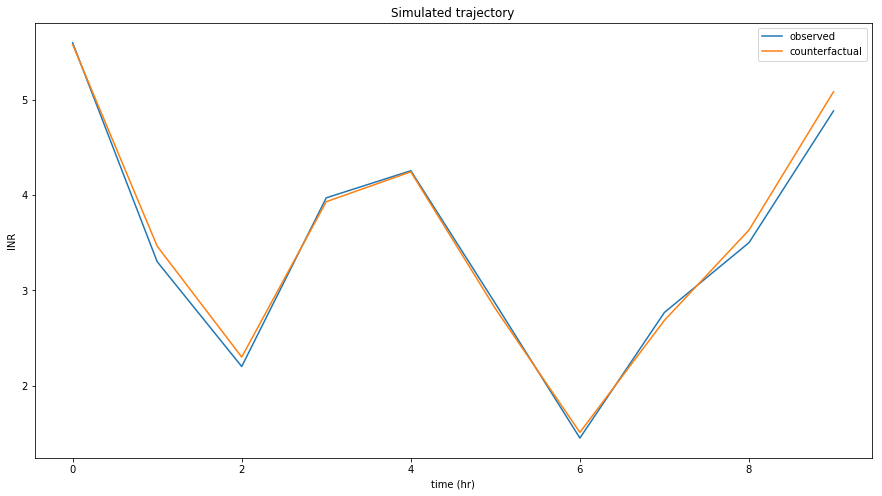

missing 0.0% of observations


In [3]:
model = Model(10, 1, 0.0)
model.run_simulation()

In [23]:
em = EM(model.y, model.X, model.c, model.A.shape[0], 0, train_pct = 1, single_effect=False)
em.run_EM(2)

init sigma 0 0.05
init sigma 1 0.05
init sigma 2 0.005
init sigma 0 0.004196010845017639
init sigma 1 1.6587752618075573
init sigma 2 0.02005869353005596
max iterations: 2 reached


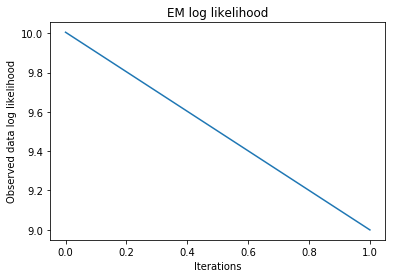

In [24]:
plt.plot([i for i in range(len(em.log_lik))], em.log_lik)
plt.xlabel('Iterations')
plt.ylabel('Observed data log likelihood')
plt.title('EM log likelihood')
plt.show()

In [25]:
em.kgain

array([[0.17299781, 0.98807665, 0.98819142, 0.98819143, 0.98819143,
        0.98819143, 0.98819143, 0.98819143, 0.98819143, 0.98819143]])

In [26]:
em.sigma_pred

array([[0.00419601, 1.66224537, 1.67859479, 1.67859709, 1.67859709,
        1.67859709, 1.67859709, 1.67859709, 1.67859709, 1.67859709]])

In [27]:
em.sigma_filter

array([[0.00347011, 0.01981953, 0.01982183, 0.01982183, 0.01982183,
        0.01982183, 0.01982183, 0.01982183, 0.01982183, 0.01982183]])

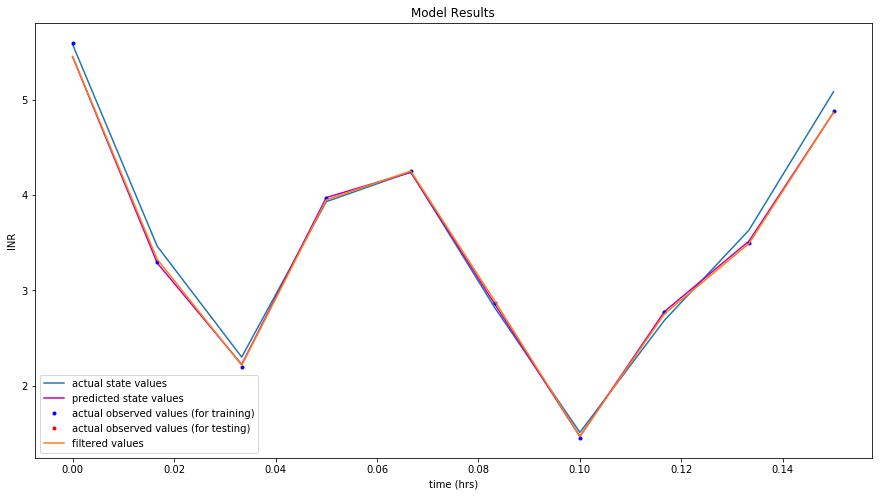

In [15]:
for n in range(model.y.shape[0]):
    plot(em, n, bin_size=1, true_model=True, model=model)

In [16]:
print('estimated A: {}'.format(em.A))
print('true A: {}'.format(model.A))
print('estimated b: {}'.format(em.b))
print('true b: {}'.format(model.b))
print('estimated initial state mean: {}'.format(em.init_z))
print('true initial state mean: {}'.format(model.init_z))
print('estimated sigma_0: {}'.format(em.sigma_0))
print('true sigma_0: {}'.format(model.noise_0))
print('estimated sigma_1: {}'.format(em.sigma_1))
print('true sigma_1: {}'.format(model.noise_1))
print('estimated sigma_2: {}'.format(em.sigma_2))
print('true sigma_2: {}'.format(model.noise_2))
print('estimated ratio: {}'.format(em.sigma_1/em.sigma_2))
print('true ratio: {}'.format(model.noise_1/model.noise_2))

estimated A: [[0. 0.]
 [0. 0.]]
true A: [[-0.9 -0.8]
 [-0.5 -0.3]]
estimated b: [0. 0.]
true b: [0.6 0.4]
estimated initial state mean: 5.451731653546587
true initial state mean: 6
estimated sigma_0: 0.002380381458220171
true sigma_0: 0.1
estimated sigma_1: 1.9183087471636466
true sigma_1: 1
estimated sigma_2: 0.02341255661793342
true sigma_2: 0.01
estimated ratio: 81.9350393239101
true ratio: 100.0


### Last Observation Carry Forward

In [17]:
# assume the first observation is not nan and the data array is not entirely nan
def LBCF(data):
    filled = np.zeros(data.shape)
    for n in range(data.shape[0]):
        for i, y in enumerate(data[n, :]):
            if np.isnan(y):
                filled[n, i] = filled[n, i-1]
            else:
                filled[n, i] = y
    return filled

### Notes on the current model

1. Identifying coefficients is still somewhat challenging (often off by a little), especially when the noises are larger.
2. When the coefficients are too small i.e. closer to the noise value, the model is unable to recover them.
3. The model has trouble identifying the noise values.  

In [69]:
a, b = 567, 236
init = 893
x, y, z = [], [], []
z.append(init)
for i in range(10):
    y.append(z[i] + a)
    x.append(y[i] / (y[i] + b))
    z.append((1 - x[i]) * y[i])

In [70]:
z_updates = []
z_updates.append(init)
for i in range(10):
    update = b * (z_updates[i] + a) / (z_updates[i] + a + b)
    z_updates.append(update)

In [71]:
z_updates

[893,
 203.16037735849056,
 180.64500764160408,
 179.37794675180913,
 179.30491621462343,
 179.30070115639023,
 179.30045785935692,
 179.3004438159649,
 179.30044300536352,
 179.30044295857465,
 179.30044295587393]

In [72]:
z

[893,
 203.16037735849065,
 180.6450076416041,
 179.37794675180913,
 179.3049162146235,
 179.3007011563902,
 179.3004578593569,
 179.30044381596488,
 179.3004430053635,
 179.30044295857468,
 179.30044295587393]

In [88]:
x_updates = []
x_updates.append(1000)
p, q, t = -2, -3, 4
for i in range(10):
    update = (-p*t*x_updates[i]-q*t)/(p*q*x_updates[i]+np.square(q)-p*t)
    x_updates.append(update)

In [89]:
x_updates

[1000,
 1.3315605783613096,
 0.9064850592906405,
 0.8579685987023468,
 0.8517206637359244,
 0.8509040991371305,
 0.8507971748030484,
 0.8507831701804359,
 0.8507813358375425,
 0.8507810955719952,
 0.8507810641015621]